# Thống kê Bayes sử dụng probflow
# Bài 4: Hồi quy logistic

### BS. Lê Ngọc Khả Nhi

# Giới thiệu

Chào các bạn, đây là bài thứ 4 trong loạt bài giới thiệu về probflow, một giao thức dựa trên tensorflow hoặc pytorch cho phép dựng các mô hình Bayes một cách dễ dàng.

Trong bài trước, chúng ta đã biết cách dựng một mô hình hồi quy tuyến tính đa biến bằng probflow và dùng nó như phương tiện trung gian nhằm so sánh giữa các phân nhóm, đó là một bài toán hồi quy với kết quả là biến số liên tục. Trong một số trường hợp khác, kết quả của mô hình hồi quy là 1 biến nhị phân, thí dụ chẩn đoán của một bệnh lý; khi đó ta có mô hình hồi quy logistic.

## Bài toán minh họa

Nhi sử dụng dataset Biopsy trong R package MASS. Dataset này là một bài toán phân loại 2 nhãn (nhị phân), dữ liệu đầu vào bao gồm 9 chỉ số về đặc tính giải phẫu bệnh lý của mô sinh thiết ở bệnh nhân có khối u Vú, và kết quả đầu ra là 1 biến định tính nhị phân về phân loại Lành tính hay ác tính của khối u.

Ta thấy phân loại Lành/Ác tính có thể được mã hóa bằng 2 con số 0 (lành tính) và 1 (ác tính), việc dựng một mô hình hồi quy logistic cho phép trả lời 2 câu hỏi:

1) Tôi muốn biết vai trò của mỗi đặc tính tế bào học góp phần định nghĩa tính chất U lành hay ác tính ? (mục tiêu diễn dịch)

2) Tôi muốn xây dựng một quy luật cho phép đưa ra quyết định phân loại một mẫu sinh thiết bất kì dựa vào các đặc tính tế bào học (mục tiêu phân loại)

In [1]:
import probflow as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

from patsy import dmatrices  # Tạo design matrix

import arviz as az

from itertools import combinations
from collections import defaultdict

# Bước 1: Chuẩn bị dữ liệu

Nhi tải dataset biopsy.csv về máy tính và save lại thành dataframe, sau đó chia ngẫu nhiên dữ liệu thành 2 tập train (huấn luyện) và validation (kiểm định) với tỉ lệ 80/20 

Dữ liệu đầu vào là 1 array 2D gồm 6 features: 
clumpthickness,ShapeUniformity,Margin_adhesion,Barenuclei,BlandChromatin

Kết quả Y được chuyển thành giá trị nhị phân (0/1)

In [2]:
col_names = ["clumpthickness",
             "SizeUniformity",
            "ShapeUniformity",
            "Margin_adhesion",
            "EpiCellSize",
            "Barenuclei",
            "BlandChromatin",
            "NormalNucleoli",
            "Mitoses",
            "Class"]

df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv",
                 sep=",",
                 index_col=0).iloc[:,1:]

df.columns = col_names

df = pd.get_dummies(df, drop_first=True).dropna()

df = df.astype('float32')
df.head()

,clumpthickness,SizeUniformity,ShapeUniformity,Margin_adhesion,EpiCellSize,Barenuclei,BlandChromatin,NormalNucleoli,Mitoses,Class_malignant
1,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
2,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
3,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
4,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
5,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=123)

feats = ["clumpthickness",
            "ShapeUniformity",
            "Margin_adhesion",
            "Barenuclei",
            "BlandChromatin"]

X_train = X_train[feats]
X_valid = X_valid[feats]

# Bước 2: Dựng mô hình logistic bằng probflow

Ta sử dụng class mô hình CategoricalModel (dùng cho bài toán có kết quả là biến định tính, nhị phân hoặc multinomial).

Từ class CategoricalModel, ta tạo ra class LogisticRegression, trong đó mục tiêu là xác định 2 nhóm tham số:

W là một ma trận các hệ số hồi quy, gồm 6 tham số w1...w6 tương ứng với 6 features trong design matrix X

b là Bias hay intercept của mô hình logistic

Kết quả Y là biến nhị phân và được ước lượng bằng phân phối Bernoulli, tương ứng với hành động chẩn đoán trên 1 trường hợp quan sát bất kì. Như ta biết, phân phối Bernoulli cũng là một quy luật phân phối cho biến rời rạc như Binomial, nó cũng khởi phát từ một hành động thử nghiệm mà kết quả chỉ có thể nhận 1 trong 2 giá trị (thí dụ 0 hoặc 1). Nhưng khác với Binomial ước lượng số lần thu được 1 kết qủa xác định (thí dụ =1) trong n lần thử, kết quả của phân phối Bernoulli ước lượng chính giá trị 0/1 cho 1 lần thử duy nhất (do đó có thể xem Bernoulli là trường hợp đặc biệt của Binomial với n=1).

Hàm mật độ xác suất cho phân phối Bernoulli rất đơn giản

$$ f(k;p) = \left\{\begin{matrix} p  (k=1)
\\ 
1-p (k=0)
\end{matrix}\right. $$

Phân phối Bernoulli chỉ có 1 tham số là p, chỉ xác suất thành công (x nhận giá trị 1). 

Trung bình của phân phối Bernoulli cũng chính là p.

Hàm likelihood của mô hình ước lượng p từ tham số W, b và dữ liệu đầu vào x thông qua hàm logit:

$Y = Binomial(p = logit(b + \mathbf{x}^\top \boldsymbol{W}) )$

In [86]:
class LogisticRegression(pf.CategoricalModel):

    def __init__(self, dims):
        self.w = pf.Parameter([dims, 1], name='Weights')
        self.b = pf.Parameter([1, 1], name='Bias')

    def __call__(self, x):
        return pf.Bernoulli(logits = x @ self.w() + self.b())

In [87]:
model = LogisticRegression(X_train.shape[1]) # dims = 6 (số features)

# Bước 3: Huấn luyện mô hình

Sau khi dựng mô hình, ta train nó trên tập X_train và y_train, thí dụ 300 epochs với batch size = 32 và learning rate = 0.01

In [88]:
model.fit(X_train.values, y_train, 
          lr = 0.01,
          batch_size=32,
          epochs=300)

# Bước 4: Suy diễn thống kê

Như thường lệ, ta có thể ước tính trung bình phân phối hậu nghiệm của ma trận tham số Weights và tham số bias:

In [89]:
model.posterior_mean()

{'Weights': array([[0.2815484 ],
        [0.42618892],
        [0.2594237 ],
        [0.376116  ],
        [0.30712318]], dtype=float32),
 'Bias': array([[-6.2930017]], dtype=float32)}

Ta có thể đối chiếu với kết quả mô hình logistic dựng bằng package statsmodels:
    
Lưu ý: statsmodel yêu cầu design matrix, bao gồm Intercept = 1

In [14]:
import statsmodels.api as sm

In [15]:
X_train_sm = X_train.copy(deep = True)
X_train_sm['Intercept'] = 1

logit = sm.Logit(y_train, X_train_sm)

logit.fit().params

Optimization terminated successfully.
         Current function value: 0.092986
         Iterations 9


clumpthickness     0.609679
ShapeUniformity    0.545566
Margin_adhesion    0.325413
Barenuclei         0.316088
BlandChromatin     0.543502
Intercept         -9.433083
dtype: float64

Có vẻ như 2 kết quả có khác biệt, sự khác biệt này có thể do giả định về prior, phân phối Binomial/Bernoulli, hoặc do việc huấn luyện mô hình chưa đạt; dù sao mô hình Bayes có tính chất bất định nên một khác biệt về giá trị trung bình các hệ số hồi quy có thể chưa phải là dấu hiệu quá xấu, ta cần xem xét toàn bộ phân bố hậu nghiệm và dĩ nhiên, khả năng dự báo chính xác của mô hình.

Method posterior_plot và prior_plot cho phép vẽ biểu đồ phân phối hậu nghiệm và so với giả thuyết tiền định:

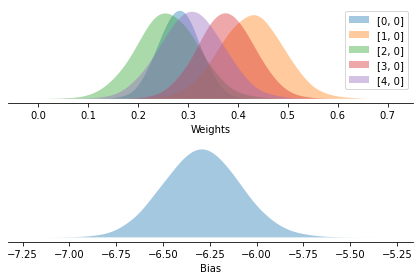

In [174]:
model.posterior_plot()

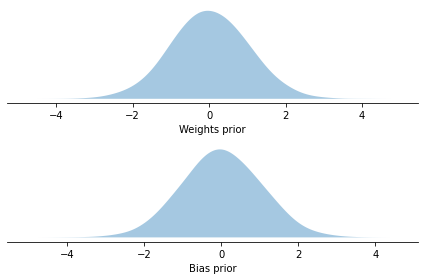

In [91]:
model.prior_plot()

Với mô hình logistic, ta thường quan tâm đến Odds-ratio chứ không phải là hệ số hồi quy, Nhi viết 1 hàm để lấy mẫu chuỗi MCMC cho Odds-ratio của 6 features và Intercept:

Hàm này xuất ra 1 arviz data object, sẵn sàng tương thích với các hàm đồ họa và summary trong arviz:

In [64]:
def odds_ratio(pf_mod = model,
               n_chain = 5000,
              features = feats,
              intercept = True):
    mcmc = model.posterior_sample(n=5000)
    
    post_dict = defaultdict()
    
    for i in enumerate(features):
        post_dict[i[1]] = tf.exp(mcmc['Weights'][:,i[0]]).numpy().reshape(n_chain//1000,1000)
    if intercept:
        post_dict['Intercept'] = tf.exp(mcmc['Bias']).numpy().reshape(n_chain//1000,1000)
    
    return az.from_dict(post_dict)

## Chuỗi MCMC của Odds-ratio

In [92]:
trace = odds_ratio(pf_mod = model,
               n_chain = 5000,
              features = feats,
              intercept = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019C84E5F048>,
      dtype=object)

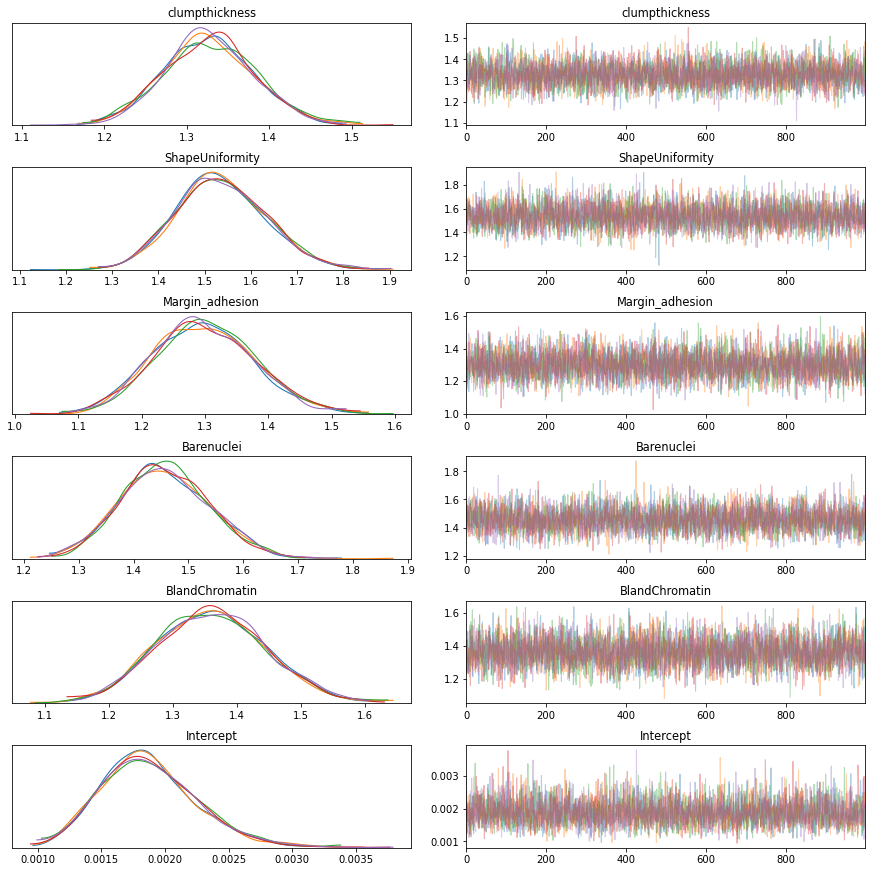

In [93]:
az.plot_trace(trace, compact = False)

## Phân phối hậu nghiệm của Odds-ratio

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019C865D8DC8>,
      dtype=object)

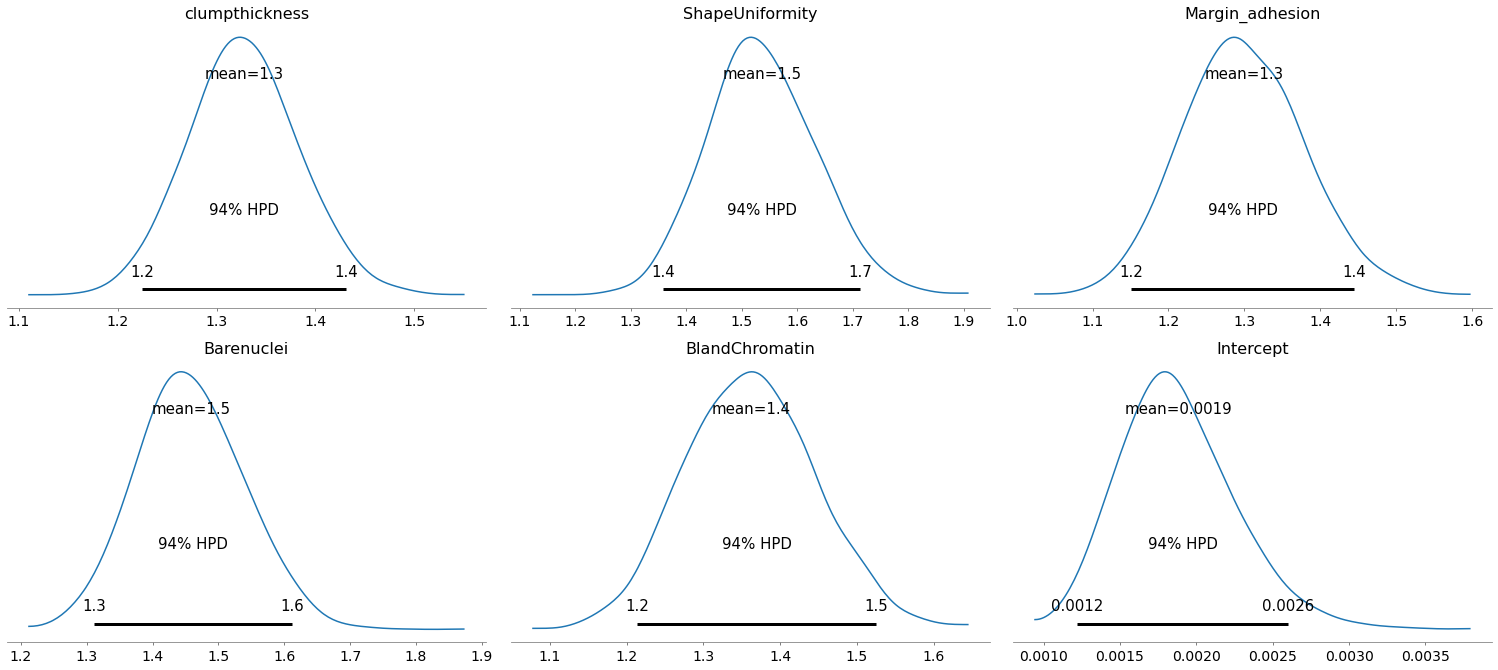

In [94]:
az.plot_posterior(trace)

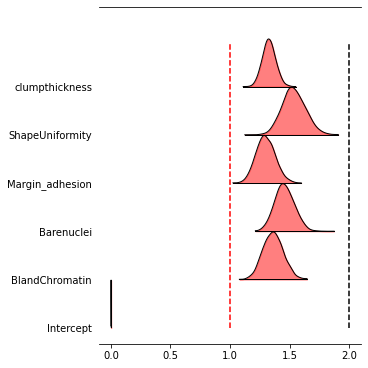

In [95]:
az.plot_forest(trace,
               kind='ridgeplot',
               colors= 'red',
               ridgeplot_alpha = 0.5,
               linewidth=1,
               combined=True,
               credible_interval = 0.95,
               ridgeplot_overlap=1.,
               figsize=(5,5))

plt.vlines(x=1, ymin = 0, ymax = 6, color = 'red', linestyles='dashed')
plt.vlines(x=2, ymin = 0, ymax = 6, color = 'black', linestyles='dashed')

## Bảng tóm tắt kết quả: trung bình và 95%CI của Odds-ratio

In [96]:
az.summary(trace, 
           credible_interval=0.95, 
           kind = 'stats',
          stat_funcs={'Median': np.median})

,mean,sd,hpd_2.5%,hpd_97.5%,Median
clumpthickness,1.327,0.055,1.217,1.431,1.326
ShapeUniformity,1.536,0.096,1.353,1.723,1.531
Margin_adhesion,1.299,0.079,1.150,1.458,1.295
Barenuclei,1.458,0.081,1.304,1.617,1.454
BlandChromatin,1.362,0.084,1.205,1.530,1.361
Intercept,0.002,0.000,0.001,0.003,0.002


Không chỉ có thể lấy mẫu cho phân phối hậu nghiệm của các tham số, probflow còn cho phép lấy mẫu cho kết quả tiên lượng. Mô hình mà ta đang có là một mô hình xác suất, do đó có thể tồn tại vô số phiên bản mô hình khác nhau qua các mần lấy mẫu; thí dụ ta lấy mẫu 10 lần thì sẽ có 10 phiên bản mô hình khác nhau, và kết quả prediction của mỗi mô hình có thể ít nhiều khác nhau:

Để kiểm tra, Nhi làm 1 thí nghiệm nhỏ như sau:

Nhi lấy mẫu 10 phiên bản prediction của 10 mô hình trên tập X_valid, và lưu lại trong object pred_samp

In [103]:
pred_samp = model.predictive_sample(X_valid.values, n=10)

Sau đó Nhi vẽ đồ thị hàm sigmoid biểu diễn tương quan giữa biến clumpthickness và kết quả prediction của 10 mô hình

In [141]:
temp_df = pd.DataFrame({'Feature':X_valid.values[:,0],
                           'Class':pred_samp[i,:,:].flatten(),
                           'Sample': 0})

for i in np.arange(1,10):
    temp_df = pd.concat([temp_df,
                         pd.DataFrame({'Feature':X_valid.values[:,0],
                           'Class':pred_samp[i,:,:].flatten(),
                           'Sample': i})])

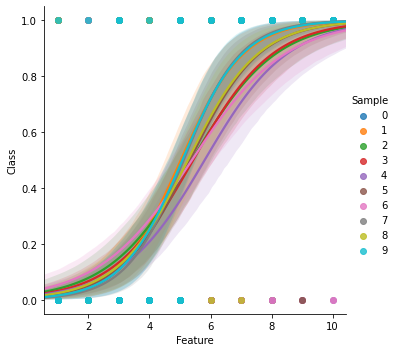

In [143]:
sns.lmplot(x='Feature',
           y='Class',
           hue = 'Sample',
           data = temp_df,
           logistic=True, 
           truncate=False)

Ta thấy 10 hàm sigmoid có thể sai biệt chút ít nhưng khá đồng nhất

Lưu ý: method predict của mô hình logistic của probflow xuất ra kết quả là probability; 
method predictive_sample xuất ra kết quả là giá trị nhị phân của Y

Ta có thể làm 1 phân tích đường cong ROC, theo kết quả này mô hình logistic của chúng ta có AUC = 0.995 trên tập train và AUC = 0.999 trên tập validation.

In [170]:
def ROC(model, X, Y):
    from sklearn.metrics import roc_curve, auc
    
    y_score = model.predict(X.values).flatten()
    fpr,tpr,_ = roc_curve(Y.values,y_score)
    AUC = auc(fpr, tpr)
    
    plt.figure(figsize = (5,5))
    lw = 2
    plt.plot(fpr, tpr, color='red',
             lw=lw, label=f'AUC = {AUC:.5f}')
    plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

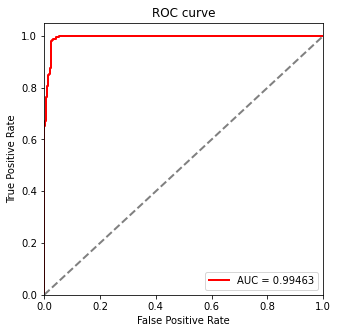

In [171]:
ROC(model, X_train, y_train)

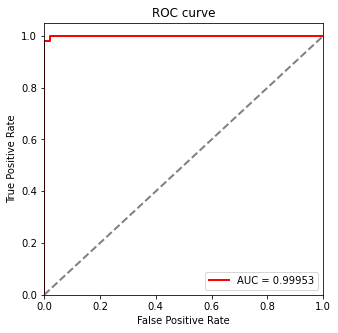

In [187]:
ROC(model, X_valid, y_valid)

# Kết luận

Một lần nữa ta thấy probflow là một giao thức đơn giản và dễ sử dụng, thích hợp hơn cho những phân tích thống kê thông thường như hồi quy logistic.

Hẹn gặp lại lần sau :)